# Sentiment Analysis of Tweets using TweetEval Dataset

This notebook demonstrates how to build a sentiment analysis model using the TweetEval dataset, which contains tweets labeled as Negative, Neutral, or Positive. The workflow includes data loading, preprocessing, visualization, model training, and evaluation.

In [1]:
# Importing Dependencies
import numpy as np
import pandas as pd
import re
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## Load and Prepare the TweetEval Dataset

We use the HuggingFace `datasets` library to load the TweetEval sentiment dataset, which contains three sentiment classes: Negative, Neutral, and Positive.

In [3]:
from datasets import load_dataset

# Load the sentiment split from TweetEval
dataset = load_dataset("tweet_eval", "sentiment")

# Convert to pandas DataFrame
train_df = dataset['train'].to_pandas()
test_df = dataset['test'].to_pandas()
val_df = dataset['validation'].to_pandas()

# Combine all splits if you want more data
twitter_data = pd.concat([train_df, test_df, val_df], ignore_index=True)

# Map labels to text for clarity (optional)
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
twitter_data['label_text'] = twitter_data['label'].map(label_map)

# Rename columns for compatibility with your code
twitter_data = twitter_data.rename(columns={"text": "text", "label": "target"})


/home/ashe/code/sentiment-analysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Exploration

Let's explore the dataset: check its shape, view some samples, and visualize the class distribution.

In [4]:
# Checking the number of rows and columns
print("Shape:", twitter_data.shape)

# Printing the first 5 rows of the dataframe
display(twitter_data.head())

# Checking the distribution of target column
print("Class distribution:\n", twitter_data['target'].value_counts())
print("Label distribution:\n", twitter_data['label_text'].value_counts())

Shape: (59899, 3)


,text,target,label_text
0,"""QT @user In the original draft of the 7th boo...",2,Positive
1,"""Ben Smith / Smith (concussion) remains out of...",1,Neutral
2,Sorry bout the stream last night I crashed out...,1,Neutral
3,Chase Headley's RBI double in the 8th inning o...,1,Neutral
4,@user Alciato: Bee will invest 150 million in ...,2,Positive


Class distribution:
 target
1    27479
2    21043
0    11377
Name: count, dtype: int64
Label distribution:
 label_text
Neutral     27479
Positive    21043
Negative    11377
Name: count, dtype: int64


/tmp/ipykernel_77831/1566508892.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label_text', data=twitter_data, palette='viridis')


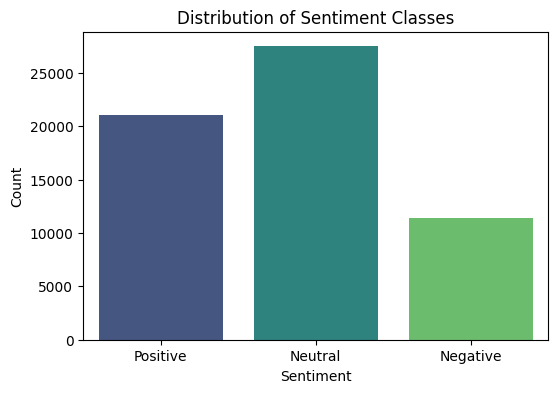

In [6]:
# Visualize the class distribution with a bar plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='label_text', data=twitter_data, palette='viridis')
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

To avoid the negative effects of an underrepresented negative sentiment class in our data

1. Class Weighting: Setting class_weight='balanced' in the Logistic Regression helps the model pay more attention to the minority class.
2. Oversampling the Minority Class
3. Undersampling the Majority Classes

In [7]:
# Show example tweets for each sentiment
for label, name in {0: "Negative", 1: "Neutral", 2: "Positive"}.items():
    print(f"\n{name} examples:")
    print(twitter_data[twitter_data['target'] == label]['text'].head(3).to_string(index=False))


Negative examples:
So disappointed in wwe summerslam! I want to se...
  That sucks if you have to take the SATs tomorrow
Amy Schumer sat down with The Hollywood Reporte...

Neutral examples:
"Ben Smith / Smith (concussion) remains out of ...
Sorry bout the stream last night I crashed out ...
Chase Headley's RBI double in the 8th inning of...

Positive examples:
"QT @user In the original draft of the 7th book...
@user Alciato: Bee will invest 150 million in J...
@user LIT MY MUM 'Kerry the louboutins I wonder...


## Data Preprocessing

We preprocess the tweets by removing non-alphabetic characters, converting to lowercase, removing stopwords, and applying stemming.

In [ ]:
# Initialize the Porter Stemmer
port_stem = PorterStemmer()

# Define a function to preprocess and stem the tweet text
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

# Shuffle the dataset (optional, but helps with randomness)
twitter_data = twitter_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Download NLTK stopwords
nltk.download('stopwords')

# Apply the stemming function to the tweet text and create a new column
twitter_data['stemmed_content'] = twitter_data['text'].apply(stemming)

[nltk_data] Downloading package stopwords to /home/ashe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Feature Extraction

Convert the preprocessed text data into numerical features using TF-IDF vectorization.

In [9]:
# Separating the data and label
X = twitter_data['stemmed_content'].values
Y = twitter_data['target'].values

# Splitting the data into training data and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

# Converting the textual data to numerical data
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

# Save the vectorizer to 'vectorizer.pkl'
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

## Training the Machine Learning Model

We use Logistic Regression for sentiment classification.

Model Choice:


Logistic Regression is a popular choice for text classification tasks like sentiment analysis because:

- **Simplicity**: It is easy to implement and interpret.
- **Efficiency**: It trains quickly, even on large datasets.
- **Works well with sparse data**: Text data transformed by TF-IDF or bag-of-words is sparse, and Logistic Regression handles this well.
- **Baseline performance**: It often provides strong baseline results for classification tasks.

Other options could be: 
- **Naive Bayes**
- **SVM (Support Vector Machine)**
- **Random Forest**

In [10]:
# Train the Logistic Regression model
model = LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga')
model.fit(X_train, Y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'saga'
,max_iter,1000
,multi_class,'deprecated'


- LogisticRegression is a linear model for classification that estimates the probability of a class label using a logistic (sigmoid) function. It is widely used for text classification tasks like sentiment analysis.

- These parameters control regularization, optimization, class balancing, and convergence for the Logistic Regression model, making it flexible and robust for text classification tasks.

## Model Evaluation

Evaluate the model's performance on both training and test data.

Accuracy Score

In [11]:
# Accuracy on training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
print('Accuracy on the training data: ', training_data_accuracy)

# Accuracy on test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy on the test data: ', test_data_accuracy)

Accuracy on the training data:  0.7731380037146017
Accuracy on the test data:  0.6417362270450752


## Saving the Trained Model

Save the trained model to disk for future use.

In [12]:
filename = 'trained_model.sav'
pickle.dump(model, open(filename, 'wb'))

## Using the Saved Model for Future Predictions

Load the saved model and vectorizer, and define a function to predict sentiment for new input text.

Using the saved model for future predictions

In [13]:
# Loading the saved model
loaded_model = pickle.load(open(filename, 'rb'))

# Example prediction
X_new = X_test[3]
print("True label:", Y_test[3])

prediction = loaded_model.predict(X_new)
print("Predicted label:", prediction)

if (prediction[0]==2):
    print('Positive')
elif (prediction[0]==1):
    print('Neutral')
else:
    print('Negative')

True label: 1
Predicted label: [2]
Positive


## Predict Sentiment for Custom Input

Define a function to preprocess, vectorize, and predict sentiment for any input text.

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Initialize stemmer
port_stem = PorterStemmer()

stop_words = set(stopwords.words('english')) - {'not', 'no', "don't", "isn't", "wasn't", "aren't", "weren't", "won't", "wouldn't", "shouldn't", "couldn't", "doesn't", "didn't", "can't"}

def predict_sentiment(input_text):
    # Preprocess
    stemmed_content = re.sub('[^a-zA-Z]', ' ', input_text)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if word not in stop_words]
    final_text = ' '.join(stemmed_content)

    # Vectorize and predict
    vectorized_input = vectorizer.transform([final_text])
    prediction = loaded_model.predict(vectorized_input)

    # Result
    if prediction[0] == 2:
        sentiment = "✅ Positive"
    elif prediction[0] == 1:
        sentiment = "😐 Neutral"
    else:
        sentiment = "❌ Negative"
    print(f"Input: {input_text}")
    print(f"Predicted Sentiment: {sentiment}")

# Example usage
predict_sentiment("he lives in a newyork city")
predict_sentiment("")
predict_sentiment("i play football")
predict_sentiment("i hate this movie")
predict_sentiment("Keep up the good work!")
predict_sentiment("Congratulations, you're a rising start")

Input: he lives in a newyork city
Predicted Sentiment: 😐 Neutral
Input: i play football
Predicted Sentiment: 😐 Neutral
Input: i hate this movie
Predicted Sentiment: ❌ Negative
Input: Keep up the good work!
Predicted Sentiment: ✅ Positive
Input: Congratulations, you're a rising start
Predicted Sentiment: ✅ Positive


## Class Distribution

Check the distribution of sentiment classes in the dataset.

In [18]:
twitter_data['target'].value_counts()

target
1    27479
2    21043
0    11377
Name: count, dtype: int64